In [1]:
!pip install requests fredapi pandas schedule

In [2]:
import requests
import json
import pandas as pd

# Your BLS API key (register at https://data.bls.gov/registrationEngine/)
bls_api_key = "58d8a969b3424879b55320f337696d8a"

# Define JOLTS series IDs and sector names
jolt_series = {
    "JTS000000000000000JOL": "Total_Nonfarm_Job_Openings",
    "JTS300000000000000JOL": "Manufacturing_Job_Openings",
    "JTS600000000000000JOL": "Professional_Services_Job_Openings",
    "JTS700000000000000JOL": "Leisure_Hospitality_Job_Openings",
}

# Month mapping from full names to two-digit numbers
month_mapping = {
    "January": "01", "February": "02", "March": "03", "April": "04",
    "May": "05", "June": "06", "July": "07", "August": "08",
    "September": "09", "October": "10", "November": "11", "December": "12"
}

# Function to remove outliers using the IQR method and fill missing data
def remove_outliers_and_fill(df, column='value'):
    """
    Remove outliers based on the IQR method and apply forward or backward fill for missing values.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows where values are outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Apply forward fill (or backward fill if needed) to fill missing values
    df[column] = df[column].ffill().bfill()  # Forward fill first, then backward fill

    return df

# Function to fetch data for a given year range
def fetch_data(start_year, end_year):
    data = {
        "registrationKey": bls_api_key,
        "seriesid": list(jolt_series.keys()),
        "startyear": str(start_year),
        "endyear": str(end_year)
    }

    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
    headers = {"Content-Type": "application/json"}

    # Send POST request
    response = requests.post(url, data=json.dumps(data), headers=headers)

    if response.status_code != 200:
        raise Exception(f"BLS API error: {response.status_code}")

    return response.json()

# Combine data from different decades
combined_data = []

# Fetch data by decades (2000-2009, 2010-2019, 2020-2025)
for start_year, end_year in [(2000, 2009), (2010, 2019), (2020, 2025)]:
    json_response = fetch_data(start_year, end_year)

    # Extract and clean data
    for series in json_response['Results']['series']:
        series_id = series['seriesID']
        sector_name = jolt_series.get(series_id, "Unknown_Sector")
        series_data = series['data']

        df = pd.DataFrame(series_data)

        # Map full month names to numeric strings
        df['month'] = df['periodName'].map(month_mapping)
        df = df[df['month'].notna()]  # Remove non-month rows like 'Annual'

        # Create proper date column
        df['date'] = pd.to_datetime(df['year'] + '-' + df['month'], format='%Y-%m')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df['sector'] = sector_name

        # Remove outliers and apply forward/backward fill
        df = remove_outliers_and_fill(df)

        # Keep relevant columns
        combined_data.append(df[['date', 'value', 'sector']])

# Combine all sectors into one DataFrame
all_sectors_df = pd.concat(combined_data, ignore_index=True)

# Pivot: one column per sector
pivot_df = all_sectors_df.pivot(index='date', columns='sector', values='value')
pivot_df = pivot_df.sort_index()
# Preview the result
print(pivot_df.head())


<ipython-input-2-d2fd249dc513>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].ffill().bfill()  # Forward fill first, then backward fill


sector      Leisure_Hospitality_Job_Openings  Manufacturing_Job_Openings  \
date                                                                       
2000-12-01                             566.0                       425.0   
2001-01-01                             654.0                       445.0   
2001-02-01                             601.0                       420.0   
2001-03-01                             695.0                       436.0   
2001-04-01                             582.0                       354.0   

sector      Professional_Services_Job_Openings  Total_Nonfarm_Job_Openings  
date                                                                        
2000-12-01                               919.0                      5088.0  
2001-01-01                               842.0                      5234.0  
2001-02-01                               808.0                      5097.0  
2001-03-01                               818.0                      4762.0  
2001-

In [3]:
print("Start date:", pivot_df.index.min())
print("End date:", pivot_df.index.max())


Start date: 2000-12-01 00:00:00
End date: 2025-03-01 00:00:00


In [4]:
import requests
import pandas as pd

# Your FRED API key (get it from https://fred.stlouisfed.org/)
fred_api_key = "8fc0d8bd4ea5422e403a182588e4920a"

# Define FRED series IDs
fred_series = {
    "FEDFUNDS": "Federal_Funds_Rate",  # Interest rate (Federal Funds Rate)
    "CPIAUCSL": "Consumer_Price_Index",  # Inflation rate (CPI)
    "PCE": "Personal_Consumption_Expenditures",  # Consumer Spending (PCE)
    "UNRATE": "Unemployment_Rate",  # Unemployment Rate
    "ICSA": "Initial_Jobless_Claims",  # Weekly claims for unemployment benefits
    "CSUSHPINSA": "Housing_Prices"  # Housing Prices (Case-Shiller Index)
}

# Function to fetch data from FRED
def fetch_fred_data(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": fred_api_key,
        "file_type": "json",
        "frequency": "m",  # monthly frequency
        "observation_start": "2000-12-01",  # starting from 2000
        "observation_end": "2025-12-31"  # up to 2025
    }
    response = requests.get(url, params=params)
    response.raise_for_status()  # Will raise an exception for HTTP errors
    return response.json()

#Function to remove outliers
def remove_outliers(df, column='value'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Fetch data for each series and convert to DataFrame
all_fred_data = []

for series_id, series_name in fred_series.items():
    data = fetch_fred_data(series_id)

    # Extract relevant data
    observations = data["observations"]

    # Convert to DataFrame
    df = pd.DataFrame(observations)

    # Clean the data (convert date and value)
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['series_name'] = series_name

    # Remove outliers
    df = remove_outliers(df)

    # Append to all data
    all_fred_data.append(df[['date', 'value', 'series_name']])

# Combine all FRED data into a single DataFrame
fred_df = pd.concat(all_fred_data, ignore_index=True)

# Pivot: one column per economic indicator
pivot_fred_df = fred_df.pivot(index='date', columns='series_name', values='value')
pivot_fred_df = pivot_fred_df.sort_index()

# Preview the result
print(pivot_fred_df.head())


series_name  Consumer_Price_Index  Federal_Funds_Rate  Housing_Prices  \
date                                                                    
2000-12-01                  174.6                6.40         108.792   
2001-01-01                  175.6                5.98         109.215   
2001-02-01                  176.0                5.49         109.643   
2001-03-01                  176.1                5.31         110.394   
2001-04-01                  176.4                4.80         111.248   

series_name  Initial_Jobless_Claims  Personal_Consumption_Expenditures  \
date                                                                     
2000-12-01                 346000.0                             6952.2   
2001-01-01                 340000.0                             6987.4   
2001-02-01                 371250.0                             7001.8   
2001-03-01                 387200.0                             6996.7   
2001-04-01                 396750.0         

In [5]:
combined_df = pd.merge(pivot_fred_df, pivot_df, left_index=True, right_index=True, how='outer')

# Preview the result
print(combined_df.head())


            Consumer_Price_Index  Federal_Funds_Rate  Housing_Prices  \
date                                                                   
2000-12-01                 174.6                6.40         108.792   
2001-01-01                 175.6                5.98         109.215   
2001-02-01                 176.0                5.49         109.643   
2001-03-01                 176.1                5.31         110.394   
2001-04-01                 176.4                4.80         111.248   

            Initial_Jobless_Claims  Personal_Consumption_Expenditures  \
date                                                                    
2000-12-01                346000.0                             6952.2   
2001-01-01                340000.0                             6987.4   
2001-02-01                371250.0                             7001.8   
2001-03-01                387200.0                             6996.7   
2001-04-01                396750.0                       

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape and column names
print(f"Dataset shape: {combined_df.shape}")
print(f"Columns: {combined_df.columns.tolist()}")

# Data types and basic info
print(combined_df.info())


Dataset shape: (293, 10)
Columns: ['Consumer_Price_Index', 'Federal_Funds_Rate', 'Housing_Prices', 'Initial_Jobless_Claims', 'Personal_Consumption_Expenditures', 'Unemployment_Rate', 'Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Total_Nonfarm_Job_Openings']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-12-01 to 2025-04-01
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Consumer_Price_Index                292 non-null    float64
 1   Federal_Funds_Rate                  293 non-null    float64
 2   Housing_Prices                      291 non-null    float64
 3   Initial_Jobless_Claims              293 non-null    float64
 4   Personal_Consumption_Expenditures   292 non-null    float64
 5   Unemployment_Rate                   293 non-null    float64
 6   Leisure_Hospitality_Job_Openings  

In [7]:
# Check for missing values
missing_data = combined_df.isna().sum()
print(f"Missing values in each column:\n{missing_data}")

# Forward fill and backward fill for missing values
combined_df = combined_df.ffill().bfill()

# Check if there are still any missing values
missing_data_after_fill = combined_df.isna().sum()
print(f"Missing values after fill:\n{missing_data_after_fill}")


Missing values in each column:
Consumer_Price_Index                  1
Federal_Funds_Rate                    0
Housing_Prices                        2
Initial_Jobless_Claims                0
Personal_Consumption_Expenditures     1
Unemployment_Rate                     0
Leisure_Hospitality_Job_Openings      1
Manufacturing_Job_Openings            4
Professional_Services_Job_Openings    1
Total_Nonfarm_Job_Openings            1
dtype: int64
Missing values after fill:
Consumer_Price_Index                  0
Federal_Funds_Rate                    0
Housing_Prices                        0
Initial_Jobless_Claims                0
Personal_Consumption_Expenditures     0
Unemployment_Rate                     0
Leisure_Hospitality_Job_Openings      0
Manufacturing_Job_Openings            0
Professional_Services_Job_Openings    0
Total_Nonfarm_Job_Openings            0
dtype: int64


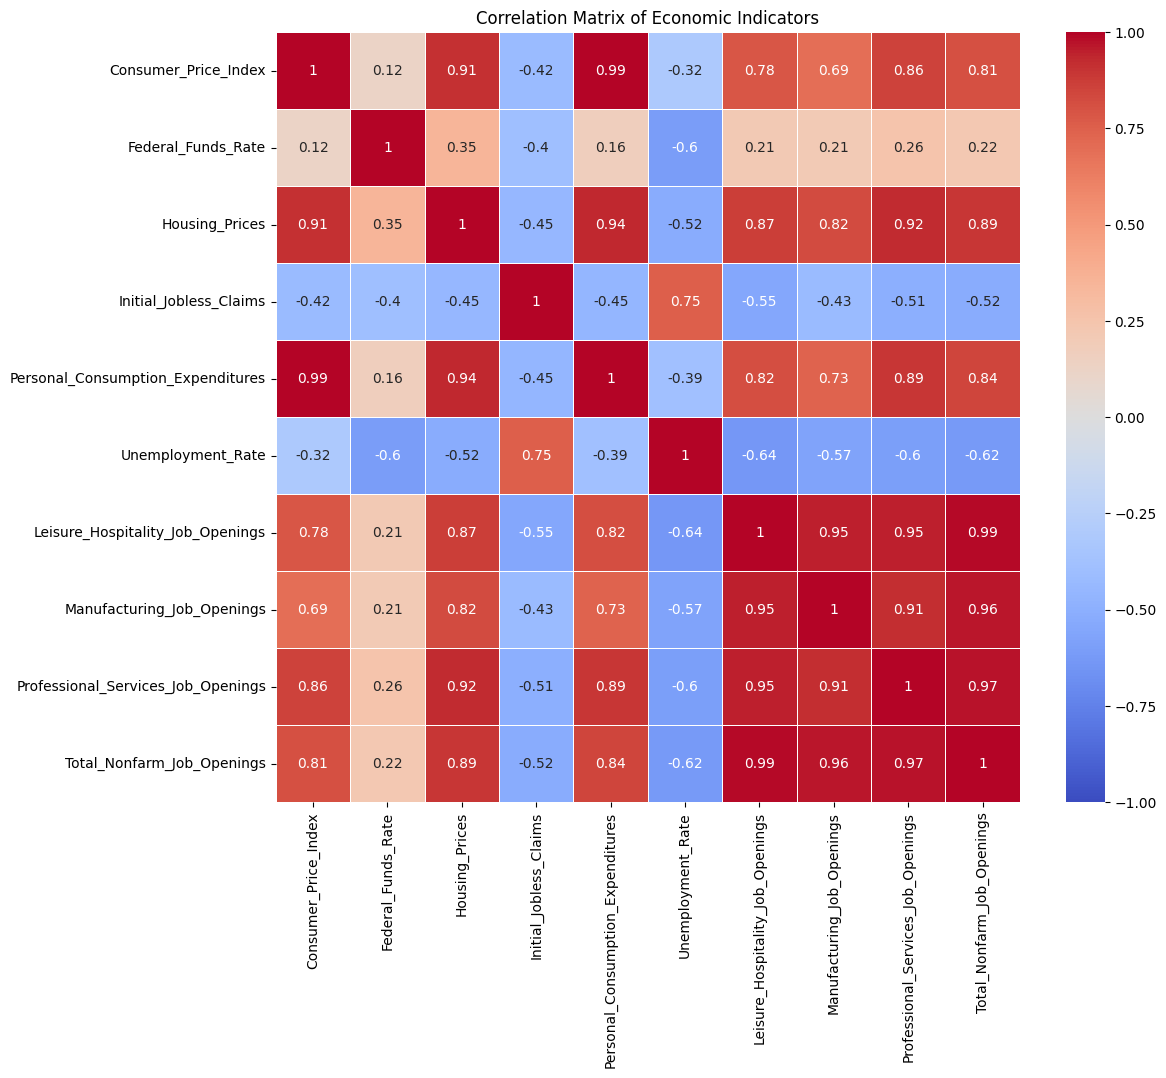

In [8]:
# Calculate the correlation matrix
corr_matrix = combined_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Economic Indicators')
plt.show()


In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# Target columns: sectors you want to forecast
target_columns = ['Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings']
# Set the frequency of the date index to monthly (MS)
combined_df.index = pd.to_datetime(combined_df.index)
combined_df.index = combined_df.index.to_period('M').to_timestamp()
combined_df.head()


,Consumer_Price_Index,Federal_Funds_Rate,Housing_Prices,Initial_Jobless_Claims,Personal_Consumption_Expenditures,Unemployment_Rate,Leisure_Hospitality_Job_Openings,Manufacturing_Job_Openings,Professional_Services_Job_Openings,Total_Nonfarm_Job_Openings
date,,,,,,,,,,
2000-12-01,174.6,6.40,108.792,346000.0,6952.2,3.9,566.0,425.0,919.0,5088.0
2001-01-01,175.6,5.98,109.215,340000.0,6987.4,4.2,654.0,445.0,842.0,5234.0
2001-02-01,176.0,5.49,109.643,371250.0,7001.8,4.2,601.0,420.0,808.0,5097.0
2001-03-01,176.1,5.31,110.394,387200.0,6996.7,4.3,695.0,436.0,818.0,4762.0
2001-04-01,176.4,4.80,111.248,396750.0,7004.2,4.4,582.0,354.0,708.0,4615.0


In [10]:
target_columns = [
    'Leisure_Hospitality_Job_Openings',
    'Manufacturing_Job_Openings',
    'Professional_Services_Job_Openings'
]


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.tsatools import detrend
import warnings
import time

warnings.filterwarnings("ignore")
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate MAPE (mean absolute percentage error).
    Avoids division by zero by filtering out zero values.
    """
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def check_stationarity(series, name, threshold=0.05):
    """
    Perform ADF test to check stationarity after detrending.
    Return True if stationary, False otherwise.
    """
    try:
        detrended = detrend(series.dropna(), order=1)
        result = adfuller(detrended)
        p_value = result[1]
        print(f"ADF Test for {name} (after detrending): p-value = {p_value:.4f}")
        return p_value < threshold
    except ValueError as e:
        print(f"Cannot perform ADF test for {name}: {e}")
        return False

def preprocess_series(df):
    """
    Apply log transformation to high-variance series and add noise to zero-variance series.
    Return transformed DataFrame and list of log-transformed columns.
    """
    transformed_df = df.copy()
    log_columns = []

    for col in transformed_df.columns:
        std_val = transformed_df[col].std()
        print(f"Standard deviation of {col}: {std_val:.6f}")

        # Add small noise to zero-variance series
        if std_val == 0:
            print(f"Adding small noise to {col} (zero variance)")
            transformed_df[col] = transformed_df[col] + np.random.normal(0, 1e-6, len(transformed_df[col]))

        # Log transform high-variance series
        if std_val > 5000 and (transformed_df[col] > 0).all():
            print(f"Applying log transformation to {col} (high variance)")
            transformed_df[col] = np.log(transformed_df[col])
            log_columns.append(col)

    return transformed_df, log_columns

def make_stationary(df, threshold=0.05, seasonal_period=0):
    """
    Apply seasonal differencing and regular differencing to non-stationary series.
    Return differenced DataFrame, list of differenced columns, and seasonal differenced columns.
    """
    diff_df = df.copy()
    diff_columns = []
    seasonal_diff_columns = []

    for col in diff_df.columns:
        # Seasonal differencing (if seasonal_period > 0)
        if seasonal_period > 0 and len(diff_df[col]) > seasonal_period:
            print(f"Applying seasonal differencing (lag {seasonal_period}) to {col}...")
            diff_df[col] = diff_df[col].diff(seasonal_period)
            seasonal_diff_columns.append(col)

        # Check stationarity
        if not check_stationarity(diff_df[col].dropna(), col, threshold):
            print(f"Differencing {col}...")
            diff_df[col] = diff_df[col].diff()
            diff_columns.append(col)

    return diff_df.dropna(), diff_columns, seasonal_diff_columns

def inverse_transform(forecast, original_df, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period=0):
    """
    Reverse differencing, seasonal differencing, and log transformation to get forecasts in original scale.
    """
    result = forecast.copy()

    # Reverse seasonal differencing (if applied)
    for col in seasonal_diff_columns:
        if col in result.columns and seasonal_period > 0:
            seasonal_start_idx = max(0, test_start_idx - seasonal_period)
            seasonal_base = original_df[col].iloc[seasonal_start_idx:test_start_idx]
            if len(seasonal_base) < seasonal_period:
                seasonal_base = pd.concat([pd.Series([seasonal_base.iloc[0]] * (seasonal_period - len(seasonal_base))), seasonal_base])
            seasonal_result = []
            for i in range(len(result)):
                idx = i % seasonal_period
                seasonal_result.append(seasonal_base.iloc[idx] + result[col].iloc[:i+1].sum())
            result[col] = pd.Series(seasonal_result, index=result.index)

    # Reverse regular differencing
    for col in diff_columns:
        if col in result.columns:
            start_value = original_df[col].iloc[test_start_idx - 1]
            result[col] = start_value + result[col].cumsum()

    # Reverse log transformation
    for col in log_columns:
        if col in result.columns:
            result[col] = np.exp(result[col])

    return result

def run_var_model(df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags, seasonal_period, diff_columns, seasonal_diff_columns, log_columns):
    """
    Run a single VAR model with given parameters and return MAE and runtime.
    """
    start_time = time.time()

    initial_window = int(len(df_stationary) * window_size)
    step_size = forecast_horizon
    forecasts = []
    actuals = []
    forecast_dates = []
    key_vars = ['Total_Nonfarm_Job_Openings']

    print(f"\nRolling window forecasting (window size: {initial_window}, horizon: {forecast_horizon}, maxlags: {maxlags}, seasonal_period: {seasonal_period})")

    for start in range(initial_window, len(df_stationary), step_size):
        train_start = start - initial_window
        train_end = start
        test_start = start
        test_end = min(start + forecast_horizon, len(df_stationary))

        train = df_stationary.iloc[train_start:train_end]
        test = df_stationary.iloc[test_start:test_end]

        try:
            model = VAR(train)
            lag_order = model.select_order(maxlags=maxlags).aic
            print(f"Selected lag order (AIC): {lag_order}")
            results = model.fit(lag_order)
        except ValueError as e:
            print(f"Error fitting VAR: {e}")
            print("Reducing lag order to 1...")
            results = model.fit(1)
            lag_order = 1

        forecast_steps = len(test)
        forecast = results.forecast(train.values[-lag_order:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

        test_start_idx = df.index.get_loc(df.index[train_end])
        forecast_levels = inverse_transform(forecast_df, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)
        test_levels = inverse_transform(test, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)

        forecasts.append(forecast_levels)
        actuals.append(test_levels)
        forecast_dates.extend(df.index[test_start:test_end])

    forecast_all = pd.concat(forecasts)
    actual_all = pd.concat(actuals)

    # Compute MAE for Total_Nonfarm_Job_Openings
    mae = mean_absolute_error(actual_all['Total_Nonfarm_Job_Openings'], forecast_all['Total_Nonfarm_Job_Openings'])
    runtime = time.time() - start_time

    return mae, runtime, forecast_all, actual_all, forecast_dates

def simple_var_model(df, forecast_horizon=4, window_size=0.5):
    """
    Test multiple seasonal periods and lag orders to find the best fit VAR model.
    """
    # Verify data size and columns
    print(f"\nInput df: {len(df)} rows, {len(df.columns)} columns")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Preprocess series
    df_no_date = df.copy()  # Since date is in index, no need to drop
    df_transformed, log_columns = preprocess_series(df_no_date)
    print(f"Log-transformed columns: {log_columns}")

    # Test multiple seasonal periods and maxlags
    seasonal_periods = [0, 3, 6, 12]  # 0 (none), quarterly, semi-annual, annual
    maxlags_values = [2, 4, 6, 8]
    results = []
    key_vars = ['Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings',
                'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']

    for seasonal_period in seasonal_periods:
        # Apply seasonal differencing for the current period
        df_stationary, diff_columns, seasonal_diff_columns = make_stationary(df_transformed, threshold=0.05, seasonal_period=seasonal_period)
        print(f"Differenced columns: {diff_columns}")
        print(f"Seasonally differenced columns: {seasonal_diff_columns}")

        if df_stationary.empty or len(df_stationary.columns) < 2:
            print(f"Error: Insufficient valid series for VAR modeling with seasonal_period={seasonal_period}")
            continue

        for maxlags in maxlags_values:
            print(f"\nTesting seasonal_period={seasonal_period}, maxlags={maxlags}")
            mae, runtime, forecast_all, actual_all, forecast_dates = run_var_model(
                df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags,
                seasonal_period, diff_columns, seasonal_diff_columns, log_columns
            )
            results.append({
                'seasonal_period': seasonal_period,
                'maxlags': maxlags,
                'mae': mae,
                'runtime': runtime,
                'forecast_all': forecast_all,
                'actual_all': actual_all,
                'forecast_dates': forecast_dates
            })
            print(f"MAE (Total_Nonfarm_Job_Openings): {mae:.2f}, Runtime: {runtime:.2f} seconds")

    # Find best configuration
    if not results:
        print("Error: No valid models were trained.")
        return None, None, None

    best_result = min(results, key=lambda x: x['mae'])
    print(f"\nBest Configuration: seasonal_period={best_result['seasonal_period']}, maxlags={best_result['maxlags']}")
    print(f"Best MAE (Total_Nonfarm_Job_Openings): {best_result['mae']:.2f}, Runtime: {best_result['runtime']:.2f} seconds")

    # Compute detailed accuracy for best configuration
    forecast_all = best_result['forecast_all']
    actual_all = best_result['actual_all']
    forecast_dates = best_result['forecast_dates']
    print("\nModel Accuracy for Best Configuration (on level values, rolling window):")
    for var in key_vars:
        if var in actual_all.columns:
            mae = mean_absolute_error(actual_all[var], forecast_all[var])
            rmse = np.sqrt(mean_squared_error(actual_all[var], forecast_all[var]))
            mape = mean_absolute_percentage_error(actual_all[var], forecast_all[var])
            print(f"{var} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


    # Plot forecasted vs actual for best configuration
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(key_vars, 1):
        if var in actual_all.columns:
            plt.subplot(2, 2, i)
            plt.plot(forecast_dates, actual_all[var], label='Actual')
            plt.plot(forecast_dates, forecast_all[var], label='Forecast')
            plt.title(f"{var} (Levels)")
            plt.xlabel("Date")
            plt.ylabel(var)
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
    plt.tight_layout()
    try:
        plt.savefig('forecast_vs_actual.png')
        print("\nPlot saved as 'forecast_vs_actual.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.close()

    return best_result['seasonal_period'], best_result['maxlags'], forecast_all

# Run the model
if combined_df is not None:
    print("\nFitting VAR model with hyperparameter tuning...")
    best_seasonal_period, best_maxlags, forecast_df = simple_var_model(combined_df, forecast_horizon=1, window_size=0.6)

    if forecast_df is not None:
        print(f"\nBest parameters: seasonal_period={best_seasonal_period}, maxlags={best_maxlags}")
        print("\nForecast Sample (First 5 Rows, level values):")
        print(forecast_df.head())
else:
    print("Error: combined_df is None")


Fitting VAR model with hyperparameter tuning...

Input df: 293 rows, 10 columns
Columns: ['Consumer_Price_Index', 'Federal_Funds_Rate', 'Housing_Prices', 'Initial_Jobless_Claims', 'Personal_Consumption_Expenditures', 'Unemployment_Rate', 'Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Total_Nonfarm_Job_Openings']
Date range: 2000-12-01 00:00:00 to 2025-04-01 00:00:00
Standard deviation of Consumer_Price_Index: 38.256581
Standard deviation of Federal_Funds_Rate: 1.883712
Standard deviation of Housing_Prices: 54.085218
Standard deviation of Initial_Jobless_Claims: 112454.384764
Applying log transformation to Initial_Jobless_Claims (high variance)
Standard deviation of Personal_Consumption_Expenditures: 3612.341129
Standard deviation of Unemployment_Rate: 1.869189
Standard deviation of Leisure_Hospitality_Job_Openings: 357.374141
Standard deviation of Manufacturing_Job_Openings: 180.215722
Standard deviation of Professional_Service

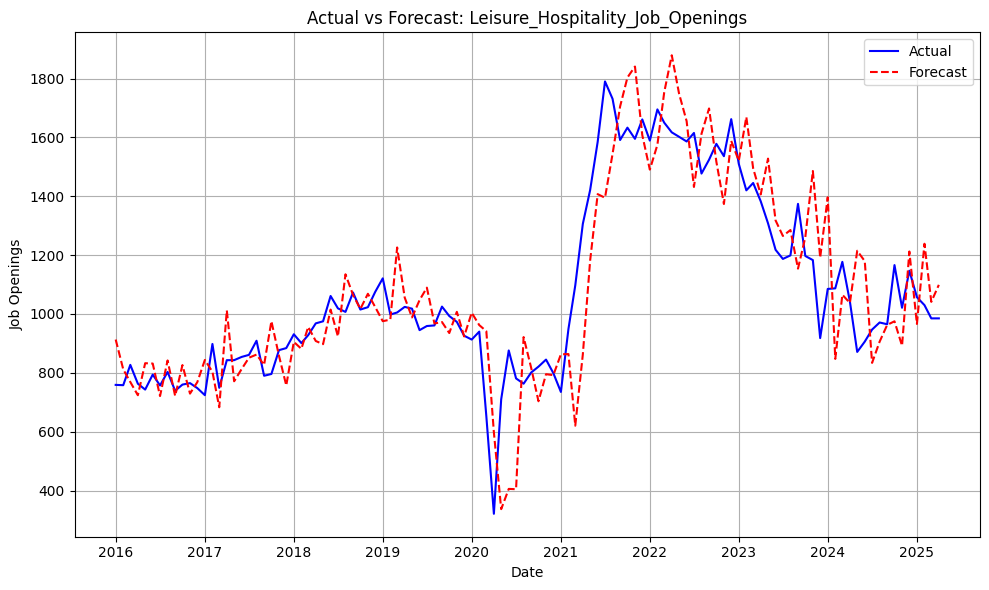

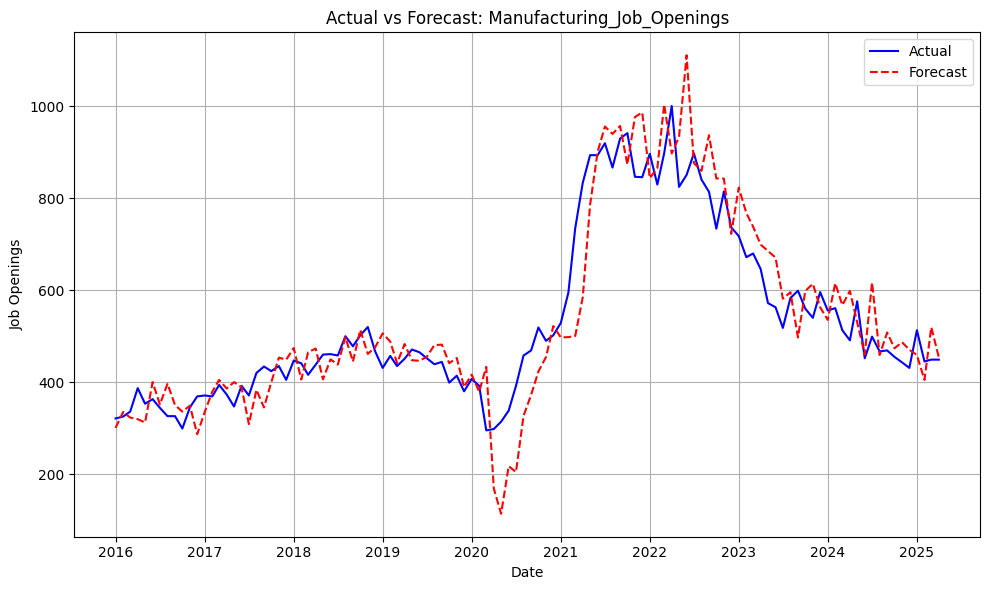

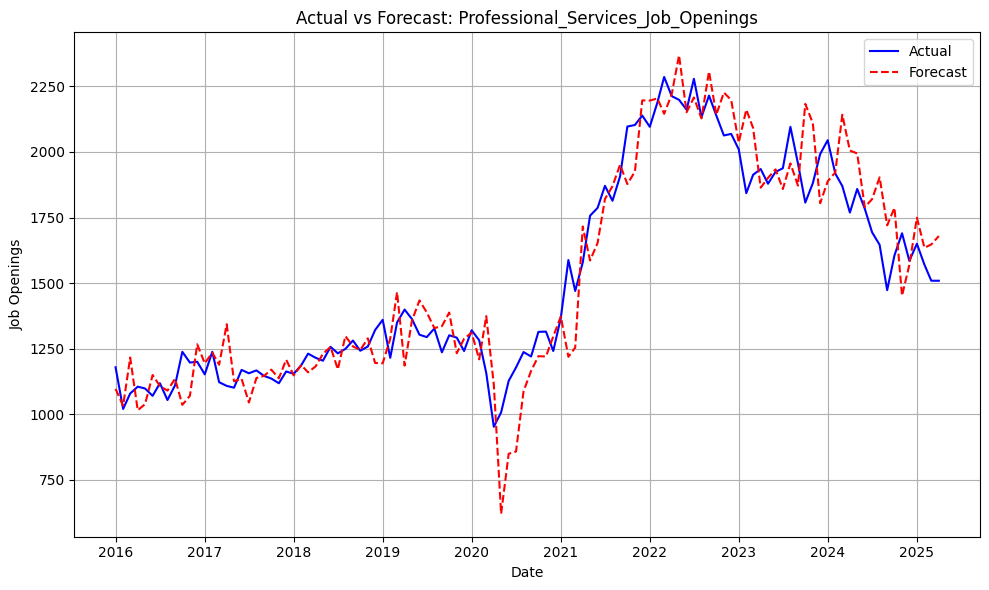

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Make a copy to avoid modifying the original
log_data = np.log(combined_df)

# Differencing to make stationary
diff_log_data = log_data.diff().dropna()

# Inverse transformation functions
def invert_transformation(last_observed, forecast_diff):
    forecast_log = forecast_diff.cumsum(axis=0) + last_observed
    return np.exp(forecast_log)

# Rolling-window VAR function
def rolling_var_forecast(data, target_columns, window_size, forecast_steps):
    forecast_results = {col: [] for col in target_columns}
    forecast_index = []

    for start in range(0, len(data) - window_size - forecast_steps + 1, forecast_steps):
        train = data[start:start + window_size]
        test_index = data.index[start + window_size:start + window_size + forecast_steps]

        model = VAR(train)
        lag_order = model.select_order(maxlags=4).aic
        var_model = model.fit(lag_order)

        last_observed_log = log_data.iloc[start + window_size - 1]

        forecast_diff = var_model.forecast(train.values[-var_model.k_ar:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast_diff, index=test_index, columns=data.columns)

        # Invert transform
        forecast_actual = invert_transformation(last_observed_log, forecast_df)

        for col in target_columns:
            forecast_results[col].extend(forecast_actual[col].values)
        forecast_index.extend(test_index)

    forecast_final_df = pd.DataFrame(index=forecast_index)
    for col in target_columns:
        forecast_final_df[col] = forecast_results[col]

    return forecast_final_df

# Parameters
target_columns = [
    'Leisure_Hospitality_Job_Openings',
    'Manufacturing_Job_Openings',
    'Professional_Services_Job_Openings'
]
window_size = 180
forecast_steps = 1

# Run rolling VAR forecast
forecast_df = rolling_var_forecast(diff_log_data, target_columns, window_size, forecast_steps)

# Plot actual vs forecast
for col in target_columns:
    actual = combined_df[col].loc[forecast_df.index]
    forecast = forecast_df[col]

    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f"Actual vs Forecast: {col}")
    plt.xlabel("Date")
    plt.ylabel("Job Openings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
def add_lag_features(df, lags=[1]):
    """
    Adds lagged versions of each column in the dataframe.

    Parameters:
        df (pd.DataFrame): Original DataFrame with a datetime index or 'date' column.
        lags (list): List of lag steps to add (e.g., [1, 2, 3] for 1, 2, 3-period lags).

    Returns:
        pd.DataFrame: DataFrame with lag features added.
    """
    df_lagged = df.copy()

    # If 'date' is a column, make it the index temporarily
    if 'date' in df.columns:
        df_lagged = df_lagged.set_index('date')

    for lag in lags:
        lagged = df_lagged.shift(lag)
        lagged.columns = [f"{col}_lag{lag}" for col in df_lagged.columns]
        df_lagged = pd.concat([df_lagged, lagged], axis=1)

    df_lagged = df_lagged.dropna().reset_index()
    return df_lagged

# Example usage
combined_df_lagged = add_lag_features(combined_df, lags=[1])
combined_df_lagged['date'] = pd.to_datetime(combined_df_lagged['date'])
combined_df_lagged.set_index('date', inplace=True)
combined_df_lagged.head()

,Consumer_Price_Index,Federal_Funds_Rate,Housing_Prices,Initial_Jobless_Claims,Personal_Consumption_Expenditures,Unemployment_Rate,Leisure_Hospitality_Job_Openings,Manufacturing_Job_Openings,Professional_Services_Job_Openings,Total_Nonfarm_Job_Openings,Consumer_Price_Index_lag1,Federal_Funds_Rate_lag1,Housing_Prices_lag1,Initial_Jobless_Claims_lag1,Personal_Consumption_Expenditures_lag1,Unemployment_Rate_lag1,Leisure_Hospitality_Job_Openings_lag1,Manufacturing_Job_Openings_lag1,Professional_Services_Job_Openings_lag1,Total_Nonfarm_Job_Openings_lag1
date,,,,,,,,,,,,,,,,,,,,
2001-01-01,175.6,5.98,109.215,340000.0,6987.4,4.2,654.0,445.0,842.0,5234.0,174.6,6.40,108.792,346000.0,6952.2,3.9,566.0,425.0,919.0,5088.0
2001-02-01,176.0,5.49,109.643,371250.0,7001.8,4.2,601.0,420.0,808.0,5097.0,175.6,5.98,109.215,340000.0,6987.4,4.2,654.0,445.0,842.0,5234.0
2001-03-01,176.1,5.31,110.394,387200.0,6996.7,4.3,695.0,436.0,818.0,4762.0,176.0,5.49,109.643,371250.0,7001.8,4.2,601.0,420.0,808.0,5097.0
2001-04-01,176.4,4.80,111.248,396750.0,7004.2,4.4,582.0,354.0,708.0,4615.0,176.1,5.31,110.394,387200.0,6996.7,4.3,695.0,436.0,818.0,4762.0
2001-05-01,177.3,4.21,112.203,394500.0,7052.8,4.3,527.0,327.0,812.0,4425.0,176.4,4.80,111.248,396750.0,7004.2,4.4,582.0,354.0,708.0,4615.0


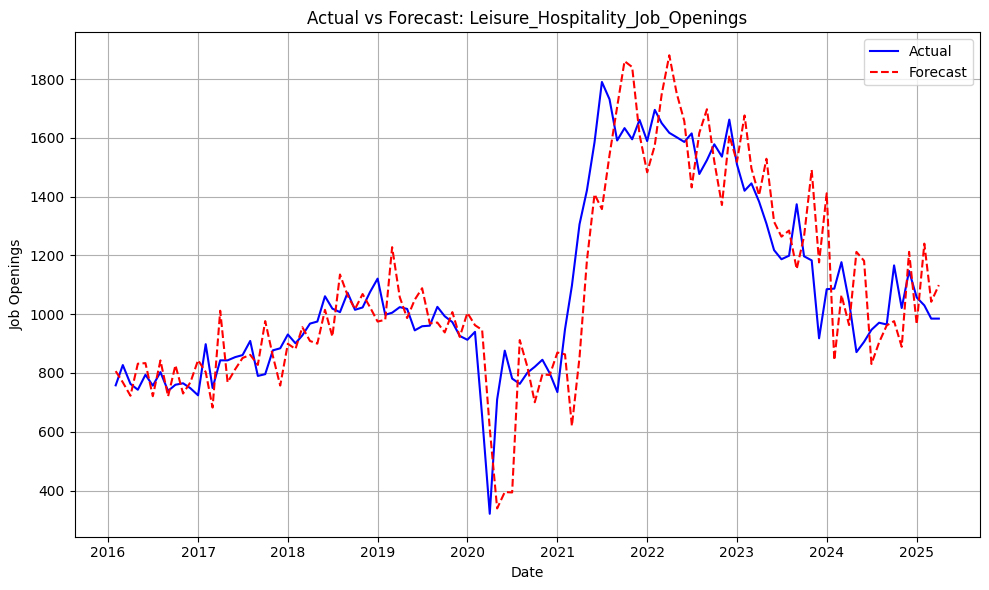

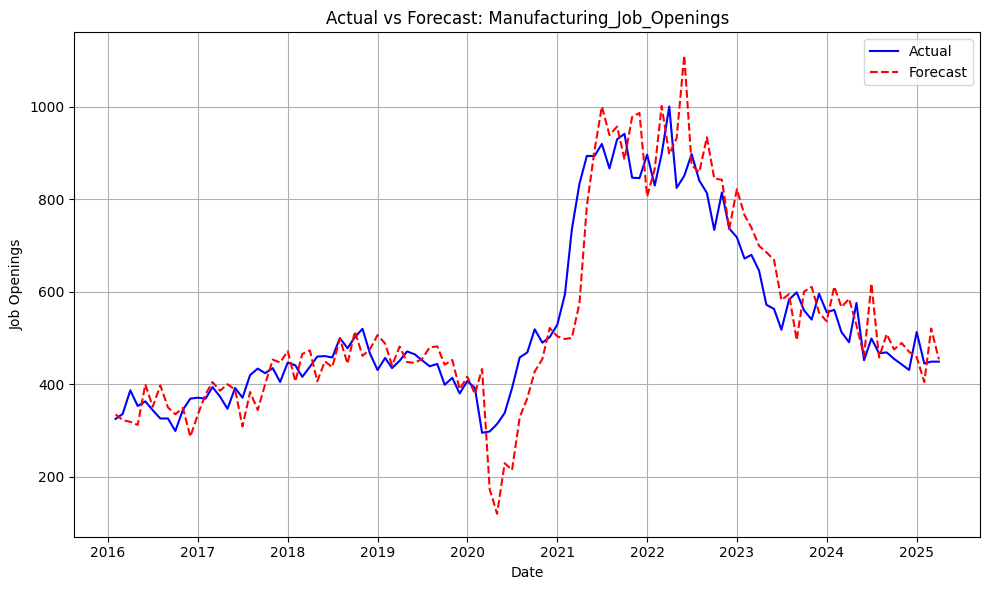

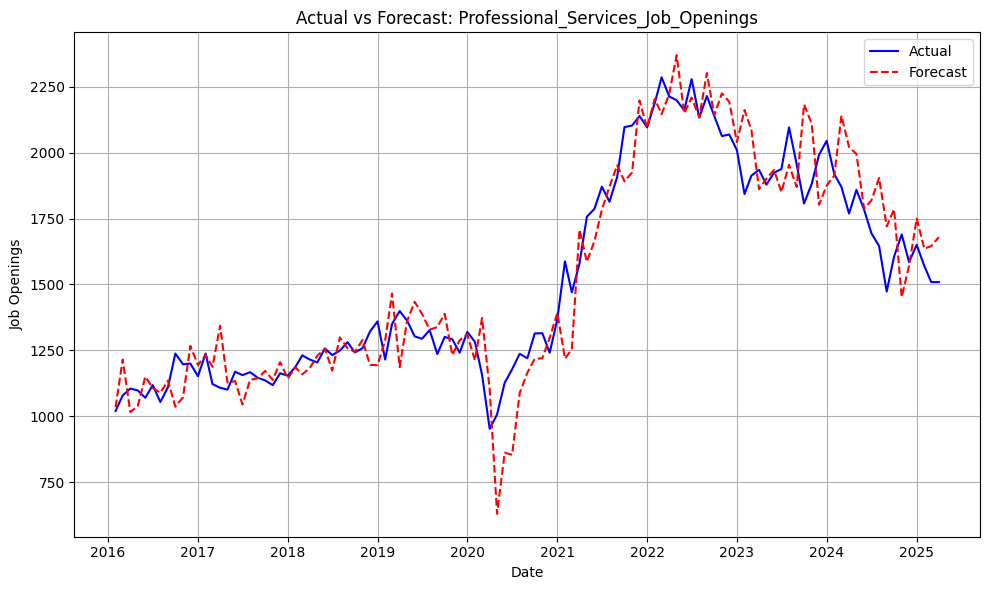

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Make a copy to avoid modifying the original
log_data = np.log(combined_df_lagged)

# Differencing to make stationary
diff_log_data = log_data.diff().dropna()

# Inverse transformation functions
def invert_transformation(last_observed, forecast_diff):
    forecast_log = forecast_diff.cumsum(axis=0) + last_observed
    return np.exp(forecast_log)

# Rolling-window VAR function
def rolling_var_forecast(data, target_columns, window_size, forecast_steps):
    forecast_results = {col: [] for col in target_columns}
    forecast_index = []

    for start in range(0, len(data) - window_size - forecast_steps + 1, forecast_steps):
        train = data[start:start + window_size]
        test_index = data.index[start + window_size:start + window_size + forecast_steps]

        model = VAR(train)
        lag_order = model.select_order(maxlags=4).aic
        var_model = model.fit(lag_order)

        last_observed_log = log_data.iloc[start + window_size - 1]

        forecast_diff = var_model.forecast(train.values[-var_model.k_ar:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast_diff, index=test_index, columns=data.columns)

        # Invert transform
        forecast_actual = invert_transformation(last_observed_log, forecast_df)

        for col in target_columns:
            forecast_results[col].extend(forecast_actual[col].values)
        forecast_index.extend(test_index)

    forecast_final_df = pd.DataFrame(index=forecast_index)
    for col in target_columns:
        forecast_final_df[col] = forecast_results[col]

    return forecast_final_df

# Parameters
target_columns = [
    'Leisure_Hospitality_Job_Openings',
    'Manufacturing_Job_Openings',
    'Professional_Services_Job_Openings'
]
window_size = 180
forecast_steps = 1

# Run rolling VAR forecast
forecast_df = rolling_var_forecast(diff_log_data, target_columns, window_size, forecast_steps)

# Plot actual vs forecast
for col in target_columns:
    actual = combined_df_lagged[col].loc[forecast_df.index]
    forecast = forecast_df[col]

    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f"Actual vs Forecast: {col}")
    plt.xlabel("Date")
    plt.ylabel("Job Openings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.tsatools import detrend
import warnings
import time

warnings.filterwarnings("ignore")

def check_stationarity(series, name, threshold=0.05):
    """
    Perform ADF test to check stationarity after detrending.
    Return True if stationary, False otherwise.
    """
    try:
        detrended = detrend(series.dropna(), order=1)
        result = adfuller(detrended)
        p_value = result[1]
        print(f"ADF Test for {name} (after detrending): p-value = {p_value:.4f}")
        return p_value < threshold
    except ValueError as e:
        print(f"Cannot perform ADF test for {name}: {e}")
        return False

def preprocess_series(df):
    """
    Apply log transformation to high-variance series and add noise to zero-variance series.
    Return transformed DataFrame and list of log-transformed columns.
    """
    transformed_df = df.copy()
    log_columns = []

    for col in transformed_df.columns:
        std_val = transformed_df[col].std()
        print(f"Standard deviation of {col}: {std_val:.6f}")

        # Add small noise to zero-variance series
        if std_val == 0:
            print(f"Adding small noise to {col} (zero variance)")
            transformed_df[col] = transformed_df[col] + np.random.normal(0, 1e-6, len(transformed_df[col]))

        # Log transform high-variance series
        if std_val > 5000 and (transformed_df[col] > 0).all():
            print(f"Applying log transformation to {col} (high variance)")
            transformed_df[col] = np.log(transformed_df[col])
            log_columns.append(col)

    return transformed_df, log_columns

def make_stationary(df, threshold=0.05, seasonal_period=0):
    """
    Apply seasonal differencing and regular differencing to non-stationary series.
    Return differenced DataFrame, list of differenced columns, and seasonal differenced columns.
    """
    diff_df = df.copy()
    diff_columns = []
    seasonal_diff_columns = []

    for col in diff_df.columns:
        # Seasonal differencing (if seasonal_period > 0)
        if seasonal_period > 0 and len(diff_df[col]) > seasonal_period:
            print(f"Applying seasonal differencing (lag {seasonal_period}) to {col}...")
            diff_df[col] = diff_df[col].diff(seasonal_period)
            seasonal_diff_columns.append(col)

        # Check stationarity
        if not check_stationarity(diff_df[col].dropna(), col, threshold):
            print(f"Differencing {col}...")
            diff_df[col] = diff_df[col].diff()
            diff_columns.append(col)

    return diff_df.dropna(), diff_columns, seasonal_diff_columns

def inverse_transform(forecast, original_df, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period=0):
    """
    Reverse differencing, seasonal differencing, and log transformation to get forecasts in original scale.
    """
    result = forecast.copy()

    # Reverse seasonal differencing (if applied)
    for col in seasonal_diff_columns:
        if col in result.columns and seasonal_period > 0:
            seasonal_start_idx = max(0, test_start_idx - seasonal_period)
            seasonal_base = original_df[col].iloc[seasonal_start_idx:test_start_idx]
            if len(seasonal_base) < seasonal_period:
                seasonal_base = pd.concat([pd.Series([seasonal_base.iloc[0]] * (seasonal_period - len(seasonal_base))), seasonal_base])
            seasonal_result = []
            for i in range(len(result)):
                idx = i % seasonal_period
                seasonal_result.append(seasonal_base.iloc[idx] + result[col].iloc[:i+1].sum())
            result[col] = pd.Series(seasonal_result, index=result.index)

    # Reverse regular differencing
    for col in diff_columns:
        if col in result.columns:
            start_value = original_df[col].iloc[test_start_idx - 1]
            result[col] = start_value + result[col].cumsum()

    # Reverse log transformation
    for col in log_columns:
        if col in result.columns:
            result[col] = np.exp(result[col])

    return result

def run_var_model(df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags, seasonal_period, diff_columns, seasonal_diff_columns, log_columns):
    """
    Run a single VAR model with given parameters and return MAE and runtime.
    """
    start_time = time.time()

    initial_window = int(len(df_stationary) * window_size)
    step_size = forecast_horizon
    forecasts = []
    actuals = []
    forecast_dates = []
    key_vars = ['Total_Nonfarm_Job_Openings']

    print(f"\nRolling window forecasting (window size: {initial_window}, horizon: {forecast_horizon}, maxlags: {maxlags}, seasonal_period: {seasonal_period})")

    for start in range(initial_window, len(df_stationary), step_size):
        train_start = start - initial_window
        train_end = start
        test_start = start
        test_end = min(start + forecast_horizon, len(df_stationary))

        train = df_stationary.iloc[train_start:train_end]
        test = df_stationary.iloc[test_start:test_end]

        try:
            model = VAR(train)
            lag_order = model.select_order(maxlags=maxlags).aic
            print(f"Selected lag order (AIC): {lag_order}")
            results = model.fit(lag_order)
        except ValueError as e:
            print(f"Error fitting VAR: {e}")
            print("Reducing lag order to 1...")
            results = model.fit(1)
            lag_order = 1

        forecast_steps = len(test)
        forecast = results.forecast(train.values[-lag_order:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

        test_start_idx = df.index.get_loc(df.index[train_end])
        forecast_levels = inverse_transform(forecast_df, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)
        test_levels = inverse_transform(test, df_no_date, test_start_idx, diff_columns, seasonal_diff_columns, log_columns, seasonal_period)

        forecasts.append(forecast_levels)
        actuals.append(test_levels)
        forecast_dates.extend(df.index[test_start:test_end])

    forecast_all = pd.concat(forecasts)
    actual_all = pd.concat(actuals)

    # Compute MAE for Total_Nonfarm_Job_Openings
    mae = mean_absolute_error(actual_all['Total_Nonfarm_Job_Openings'], forecast_all['Total_Nonfarm_Job_Openings'])
    runtime = time.time() - start_time

    return mae, runtime, forecast_all, actual_all, forecast_dates

def simple_var_model(df, forecast_horizon=4, window_size=0.5):
    """
    Test multiple seasonal periods and lag orders to find the best fit VAR model.
    """
    # Verify data size and columns
    print(f"\nInput df: {len(df)} rows, {len(df.columns)} columns")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")

    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Preprocess series
    df_no_date = df.copy()  # Since date is in index, no need to drop
    df_transformed, log_columns = preprocess_series(df_no_date)
    print(f"Log-transformed columns: {log_columns}")

    # Test multiple seasonal periods and maxlags
    seasonal_periods = [0, 3, 6, 12]  # 0 (none), quarterly, semi-annual, annual
    maxlags_values = [2, 4, 6, 8]
    results = []
    key_vars = ['Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings',
                'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']

    for seasonal_period in seasonal_periods:
        # Apply seasonal differencing for the current period
        df_stationary, diff_columns, seasonal_diff_columns = make_stationary(df_transformed, threshold=0.05, seasonal_period=seasonal_period)
        print(f"Differenced columns: {diff_columns}")
        print(f"Seasonally differenced columns: {seasonal_diff_columns}")

        if df_stationary.empty or len(df_stationary.columns) < 2:
            print(f"Error: Insufficient valid series for VAR modeling with seasonal_period={seasonal_period}")
            continue

        for maxlags in maxlags_values:
            print(f"\nTesting seasonal_period={seasonal_period}, maxlags={maxlags}")
            mae, runtime, forecast_all, actual_all, forecast_dates = run_var_model(
                df_stationary, df, df_no_date, forecast_horizon, window_size, maxlags,
                seasonal_period, diff_columns, seasonal_diff_columns, log_columns
            )
            results.append({
                'seasonal_period': seasonal_period,
                'maxlags': maxlags,
                'mae': mae,
                'runtime': runtime,
                'forecast_all': forecast_all,
                'actual_all': actual_all,
                'forecast_dates': forecast_dates
            })
            print(f"MAE (Total_Nonfarm_Job_Openings): {mae:.2f}, Runtime: {runtime:.2f} seconds")

    # Find best configuration
    if not results:
        print("Error: No valid models were trained.")
        return None, None, None

    best_result = min(results, key=lambda x: x['mae'])
    print(f"\nBest Configuration: seasonal_period={best_result['seasonal_period']}, maxlags={best_result['maxlags']}")
    print(f"Best MAE (Total_Nonfarm_Job_Openings): {best_result['mae']:.2f}, Runtime: {best_result['runtime']:.2f} seconds")

    # Compute detailed accuracy for best configuration
    forecast_all = best_result['forecast_all']
    actual_all = best_result['actual_all']
    forecast_dates = best_result['forecast_dates']

    print("\nModel Accuracy for Best Configuration (on level values, rolling window):")
    for var in key_vars:
        if var in actual_all.columns:
            mae = mean_absolute_error(actual_all[var], forecast_all[var])
            rmse = np.sqrt(mean_squared_error(actual_all[var], forecast_all[var]))
            print(f"{var} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot forecasted vs actual for best configuration
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(key_vars, 1):
        if var in actual_all.columns:
            plt.subplot(2, 2, i)
            plt.plot(forecast_dates, actual_all[var], label='Actual')
            plt.plot(forecast_dates, forecast_all[var], label='Forecast')
            plt.title(f"{var} (Levels)")
            plt.xlabel("Date")
            plt.ylabel(var)
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
    plt.tight_layout()
    try:
        plt.savefig('forecast_vs_actual.png')
        print("\nPlot saved as 'forecast_vs_actual.png'")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.close()

    return best_result['seasonal_period'], best_result['maxlags'], forecast_all

# Run the model
if combined_df_lagged is not None:
    print("\nFitting VAR model with hyperparameter tuning...")
    best_seasonal_period, best_maxlags, forecast_df = simple_var_model(combined_df_lagged, forecast_horizon=1, window_size=0.6)

    if forecast_df is not None:
        print(f"\nBest parameters: seasonal_period={best_seasonal_period}, maxlags={best_maxlags}")
        print("\nForecast Sample (First 5 Rows, level values):")
        print(forecast_df.head())
else:
    print("Error: combined_df is None")


Fitting VAR model with hyperparameter tuning...

Input df: 292 rows, 20 columns
Columns: ['Consumer_Price_Index', 'Federal_Funds_Rate', 'Housing_Prices', 'Initial_Jobless_Claims', 'Personal_Consumption_Expenditures', 'Unemployment_Rate', 'Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Total_Nonfarm_Job_Openings', 'Consumer_Price_Index_lag1', 'Federal_Funds_Rate_lag1', 'Housing_Prices_lag1', 'Initial_Jobless_Claims_lag1', 'Personal_Consumption_Expenditures_lag1', 'Unemployment_Rate_lag1', 'Leisure_Hospitality_Job_Openings_lag1', 'Manufacturing_Job_Openings_lag1', 'Professional_Services_Job_Openings_lag1', 'Total_Nonfarm_Job_Openings_lag1']
Date range: 2001-01-01 00:00:00 to 2025-04-01 00:00:00
Standard deviation of Consumer_Price_Index: 38.166828
Standard deviation of Federal_Funds_Rate: 1.867435
Standard deviation of Housing_Prices: 53.988020
Standard deviation of Initial_Jobless_Claims: 112647.317299
Applying log transformation